In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# from functools import partial
# import matplotlib.gridspec as gridspec
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from scipy.stats import norm

from multivariate.MVN import MultivariateNormal
from multivariate.MCMC import MetropolisHastings, Gibbs
from multivariate.multiple_chains import MultipleChains
import seaborn as sns


ModuleNotFoundError: No module named 'MCMC'

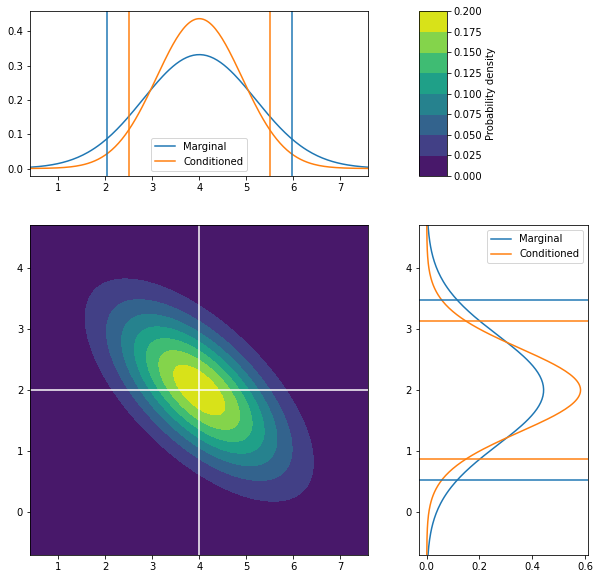

In [23]:
mean = np.array([4, 2])
covariance = np.array([
    [1.44, -.702],
    [-.702, .81]])
CL = .90

n = MultivariateNormal(mean, covariance)
# this class, defined in a separate file, has all the properties we need

n.plot_2d_analytical(4, 2, CL)
# bivariate plot of the Gaussian, including marginal distributions
# and conditioned distributions on the values provided as arguments
# and credible intervals for each univariate Gaussian 

In [24]:
# Let us see some numbers

m = n.marginalize(0)
CI_x_analytical = m.analytical_CI(CL)
print(f'The Credible Interval is between {CI_x_analytical[0]:.2f} and {CI_x_analytical[1]:.2f}')

The Credible Interval is between 2.03 and 5.97


(2.082250777739503, 6.01440960804708)


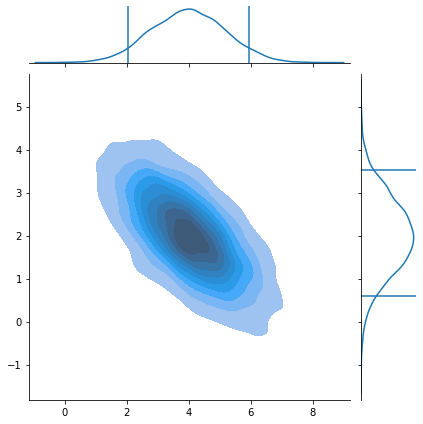

In [26]:
# CHOLESKY SAMPLING

samples_ch = n.cholesky_sample(10000)
grid = sns.jointplot(x=samples_ch[:, 0], y=samples_ch[:, 1], kind='kde', shade=True)

interval_x = MetropolisHastings.interval_from_samples(samples_ch[:,0], CL)
[grid.ax_marg_x.axvline(x) for x in interval_x]

interval_y = MetropolisHastings.interval_from_samples(samples_ch[:,1], CL)
[grid.ax_marg_y.axhline(y) for y in interval_y]


In [27]:
# METROPOLIS - HASTINGS SAMPLING

def gaussian_proposal(theta=None):
    return (np.random.normal(scale=1, size=2))

initial_positions = np.stack((np.arange(-5, 5), np.arange(-5, 5))).T

trim_amount = 1000
chain_length = 10000

mc = MultipleChains(MetropolisHastings, n.pdf, initial_positions,
                       chain_length + trim_amount, gaussian_proposal)
mc.trim_chains(trim_amount)

samples_mh = mc.all_chains
grid = sns.jointplot(x=samples_mh[:, 0], y=samples_mh[:, 1], kind='kde', shade=True)

interval_x = MetropolisHastings.interval_from_samples(samples_mh[:,0], CL)
[grid.ax_marg_x.axvline(x) for x in interval_x]

interval_y = MetropolisHastings.interval_from_samples(samples_mh[:,1], CL)
[grid.ax_marg_y.axhline(y) for y in interval_y]


NameError: name 'MultipleChains' is not defined